## *Used vehicles price prediction* - Machine Learning Models Project
## <font size=5 color='gray'>Daniel Behar</font>
The aim of this Machine Learning Model exercise is to create a regression model that can predict the price of used cars. The dataset that I used came from UK.

#### Structure of the notebook:
* `Libraries`: Includes a briefly description of where they were used in the process
* `Data Export`: Includes the data export, the cleaning of it, an analysis of its behaviour and the final categorial imputations
* `Models`: Includes all the models that I built previously to select the best one
* `Best Model`: The prediction of the test data with the best model

## Importing Libraries

In [65]:
#General use libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#To split into train and test
from sklearn.model_selection import train_test_split

#Models evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#Polynomial model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#Random Forest Model
from sklearn.ensemble import RandomForestRegressor

## Data
* Getting the data
* Extracting price from the train set (test doesn't have it)
* Creating train and test sets from de Train dataset

In [66]:
#Data will be the data that I'll use to create and train the model, datat is the data for which I want to predict the price variable
data = pd.read_csv("train.csv")
datat = pd.read_csv("test.csv")

In [67]:
datat.head()

,id,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,1,A Class,2019,Automatic,1000,Diesel,145.0,56.5,2.0,mercedes
1,2,Yaris,2016,Manual,33965,Petrol,30.0,55.0,1.3,toyota
2,3,Touran,2019,Manual,12264,Diesel,145.0,51.4,1.6,vw
3,4,Astra,2017,Semi-Auto,11536,Petrol,125.0,51.4,1.4,vauxhall
4,5,Corsa,2019,Manual,5197,Petrol,145.0,43.5,1.4,vauxhall


Because I will not use pipelines this time, after cleaning the train dataset I will separate it in train and test subsets

### Cleaning data:
* Searching for NA values and not normal observations
* Removing NAs from both datasets

How clean is the data

In [68]:
# % of NAs for each column
# Both datasets contains NAs in the same two variables
nas = pd.DataFrame(data.isna().sum()/data.shape[0], columns = ['%NAs']).reset_index()
nas
nas = pd.DataFrame(datat.isna().sum()/data.shape[0], columns = ['%NAs']).reset_index()
nas

,index,%NAs
0,id,0.000000
1,model,0.000000
2,year,0.000000
3,transmission,0.000000
4,mileage,0.000000
5,fuelType,0.000000
6,tax,0.037169
7,mpg,0.037169
8,engineSize,0.000000
9,make,0.000000


In [69]:
# searching for strange values that might be a problem
def unique(column):
    return data[column].value_counts(), datat[column].value_counts()

unique("transmission")
unique("make")
unique("year")
unique("fuelType")

(Petrol      41763
 Diesel      31739
 Hybrid       2291
 Other         180
 Electric        5
 Name: fuelType, dtype: int64,
 Petrol      18112
 Diesel      13438
 Hybrid        938
 Other          73
 Electric        1
 Name: fuelType, dtype: int64)

One year in "data" dataset was 2060, so I'll erase all observations higher than 2023, the year I did this analysis. Datat didn't had any problem

In [70]:
data = data[data.year < 2023]

* Tax and mpg are continous variables and the % of NAs in both datasets (and in both variables) is lower than 1%, so I'll impute with the mean in both variables
* None of the string variables have NAs nor atipical values

In [71]:
#Cleaning both datasets with mean
data["tax"] = data["tax"].fillna(data["tax"].mean())
data["mpg"] = data["mpg"].fillna(data["mpg"].mean())
datat["tax"] = datat["tax"].fillna(datat["tax"].mean())
datat["mpg"] = datat["mpg"].fillna(datat["mpg"].mean())

In [72]:
# % of NAs for each column
# Both datasets are free of NAs at this point
nas = pd.DataFrame(data.isna().sum()/data.shape[0], columns = ['%NAs']).reset_index()
nas
nas = pd.DataFrame(datat.isna().sum()/data.shape[0], columns = ['%NAs']).reset_index()
nas

,index,%NAs
0,id,0.0
1,model,0.0
2,year,0.0
3,transmission,0.0
4,mileage,0.0
5,fuelType,0.0
6,tax,0.0
7,mpg,0.0
8,engineSize,0.0
9,make,0.0


### Data behavior
* Extracting price from the Train set (Test doesn't have it)
* Extracting id from the Test set (it will be needed later)
* Creating train and test sets from the Train dataset

In [73]:
#Data train basic statistics
data.describe()

,year,mileage,tax,mpg,engineSize,price
count,75977.000000,75977.000000,75977.000000,75977.000000,75977.000000,75977.000000
mean,2017.099754,22967.203917,120.571147,55.194688,1.663715,16925.786830
std,2.122062,21024.550764,60.416360,15.738765,0.555868,9728.749634
min,1970.000000,1.000000,0.000000,0.300000,0.000000,450.000000
25%,2016.000000,7470.000000,120.571147,47.100000,1.200000,10277.000000
50%,2017.000000,17265.000000,145.000000,55.194688,1.600000,14750.000000
75%,2019.000000,32220.000000,145.000000,61.400000,2.000000,20980.000000
max,2020.000000,323000.000000,580.000000,470.800000,6.600000,149948.000000


In [74]:
#Data test statistics
datat.describe()

,id,year,mileage,tax,mpg,engineSize
count,32562.000000,32562.000000,32562.000000,32562.000000,32562.000000,32562.000000
mean,16281.500000,2017.092685,23161.974602,119.663394,55.102172,1.656818
std,9399.984069,2.135460,21525.931341,60.253088,14.675773,0.559808
min,1.000000,1970.000000,1.000000,0.000000,1.100000,0.000000
25%,8141.250000,2016.000000,7506.000000,119.663394,47.100000,1.200000
50%,16281.500000,2017.000000,17263.500000,145.000000,55.102172,1.600000
75%,24421.750000,2019.000000,32292.250000,145.000000,61.400000,2.000000
max,32562.000000,2020.000000,300000.000000,580.000000,470.800000,6.600000


Amazingly, there are engines of size = 0, so thats a normal observation

C:\Users\danie\AppData\Local\Temp\ipykernel_15748\3583523835.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = data.corr(method='pearson')


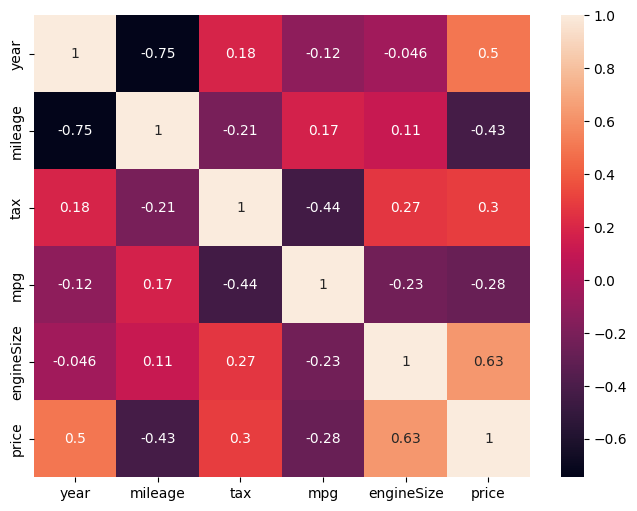

In [75]:
#Checking correlation between variables in order to avoid it
corr_df = data.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

Because -0.75 is still acceptable, I will not remove both variables

<Figure size 640x480 with 0 Axes>

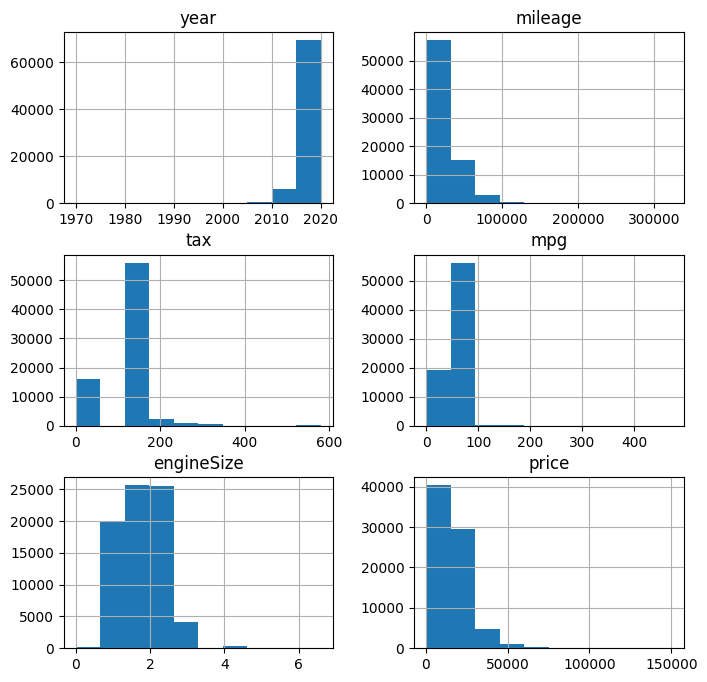

In [76]:
#Histograms of the numeric variables to identify their distributions
plt.figure()
data.hist(figsize=(8,8))
plt.show()

In [77]:
# Removing price variable from the train dataset and the ID variable from the test dataset, both will be used later
y = data.loc[:,"price"]
data.drop(["price"],axis=1,inplace=True)
id = datat.loc[:,"id"]
datat.drop(["id"],axis=1,inplace=True)
print(data.shape)
print(y.shape)
print(datat.shape)
print(id.shape)

(75977, 9)
(75977,)
(32562, 9)
(32562,)


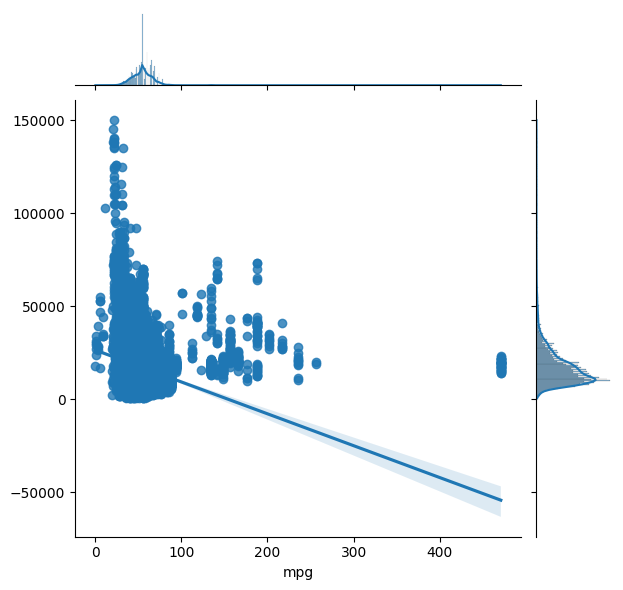

In [78]:
#Checking if a linear regression could provide a good prediction
sns.jointplot(x=data['mpg'], y=y.values.ravel(), kind='reg')

The previous graph shows that a linear model will not predict correctly

C:\Users\danie\AppData\Local\Temp\ipykernel_15748\3736863179.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['engineSize'])


<AxesSubplot: xlabel='engineSize', ylabel='Density'>

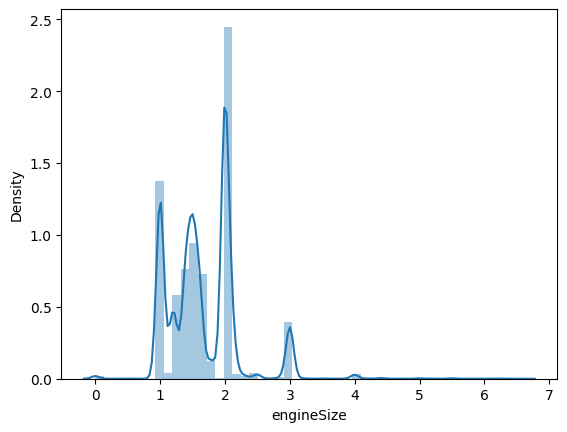

In [79]:
#Checking if a polynomial regression could fit with engineSize
sns.distplot(data['engineSize'])

There are some mountains but doesn't reflect a polynomial growth

C:\Users\danie\AppData\Local\Temp\ipykernel_15748\178970630.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['tax'])


<AxesSubplot: xlabel='tax', ylabel='Density'>

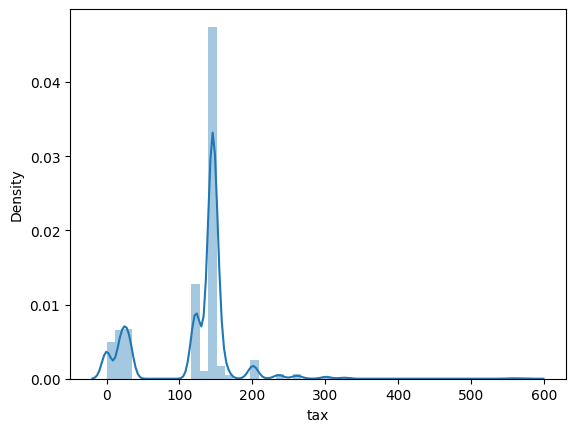

In [80]:
#Checking if a polynomial regression could fit with tax
sns.distplot(data['tax'])

C:\Users\danie\AppData\Local\Temp\ipykernel_15748\1988223004.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['mileage'])


<AxesSubplot: xlabel='mileage', ylabel='Density'>

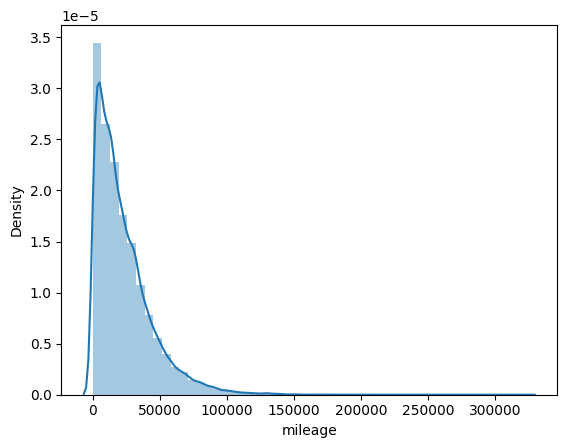

In [81]:
#Checking if a polynomial regression could fit with mileage
sns.distplot(data['mileage'])

It seems like it's decreasing with a polynomial form, I'll try a polynomial regression

### Categorical Imputations

In [82]:
#Getting close which variables will be encoded
data.dtypes

model            object
year              int64
transmission     object
mileage           int64
fuelType         object
tax             float64
mpg             float64
engineSize      float64
make             object
dtype: object

In [83]:
#Enconding with the dummies method in both dataset
data_dummies = pd.get_dummies(data)
cols = data_dummies.columns.tolist()
datat_dummies = pd.get_dummies(datat)
datat_dummies = datat_dummies.reindex(columns=cols).fillna(0)
data_dummies.head()

,year,mileage,tax,mpg,engineSize,model_1 Series,model_2 Series,model_200,model_220,model_3 Series,...,fuelType_Petrol,make_audi,make_bmw,make_ford,make_hyundai,make_mercedes,make_skoda,make_toyota,make_vauxhall,make_vw
0,2017,36874,20.0,60.1,1.2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2016,39386,20.0,60.1,1.2,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,2018,8935,145.0,57.7,1.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2016,18606,20.0,62.8,1.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,2015,26000,30.0,61.4,2.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [84]:
#Creating train and test subsets
X_train, X_test, y_train, y_test = train_test_split(data_dummies, y, test_size=0.3, random_state=20)

## Models
I will try various models to select the best one. I´m using Mean Absolute Error (MAE) to evaluate all the model’s performance

### Polynomial model

In [85]:
#Preparing the polinomial model
model1 = PolynomialFeatures(degree = 3)

model1_train = model1.fit_transform(pd.DataFrame(X_train['mileage']))
model1_test = model1.fit_transform(pd.DataFrame(X_test['mileage']))

In [86]:
#Fit linear model with polynomial features
model1_model = LinearRegression()

model1_result = model1_model.fit(model1_train, y_train)
model1_pred = model1_model.predict(model1_test)

mean_absolute_error(y_test, model1_pred)

6076.34099626199

This MAE its really big, although the model has reached his optimal minimum

### Random Forest Regression

In [25]:
#Using randomized grid search to identify the best hyperparams to the random forest model
params = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=200),
    'random_state': randint(low=1, high=200),
}

model2_estim = RandomForestRegressor()
rnd_search = RandomizedSearchCV(model2_estim, param_distributions=params,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D36F8E3130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D36F5CA910>},
                   random_state=42, scoring='neg_mean_squared_error')

In [27]:
#Grid search best case
rnd_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=152, random_state=42)

Because its REALLY EXPENSIVE to compute the random grid search, I adjusted the random_state manually

In [87]:
#Best final random forest model
model2_model = RandomForestRegressor(random_state=93, n_estimators=180, max_features=103)

model2_result = model2_model.fit(X_train, y_train)
model2_pred = model2_model.predict(X_test)

mean_absolute_error(y_test, model2_pred)

1189.0248804719752

## Saving best model
* The best model was the Random Forest with the hyperparams calculated
* Because I uploaded the answers to Kaggle, I need to merge the ID of the car information and the price prediction result

In [88]:
price = model2_model.predict(datat_dummies)
solutions = pd.concat([id, pd.DataFrame(price)], axis=1)
solutions.to_csv('solutions.csv')